In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

%load_ext tensorboard
import datetime

# Positional encoding

In [2]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # Get i from dimension span k
    i = np.floor(k / 2)
    # Calculate the angles using pos, i and d
    # This is the original formulations from Attention is all you need:
    #angles = pos / (np.power(10000, 2 * i / d))
    # Alternative that assigns higher frequencies:
    angles = 0.5 * np.pi * pos / (np.power(100, 2 * i / d))
    
    return angles

def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.reshape(range(0, positions), (positions, 1)),
                            np.reshape(range(0, d), (1, d)),
                            d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

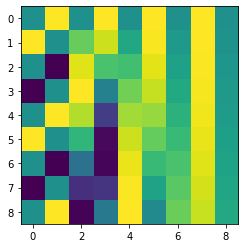

In [3]:
pos_encodings = positional_encoding(9, 9)
plt.imshow(pos_encodings[0])

# ThoughtNet layers

In [70]:
class ThoughtBranchLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dims, positional_encoding_dims, num_inner_layers, name=None):
        super(ThoughtBranchLayer, self).__init__(name=name)
        
        self.embedding_dims = embedding_dims
        self.positional_encoding_dims = positional_encoding_dims
        
        self.input_with_positional_encoding_layer = Concatenate(axis=-1, name="input_with_positional_encoding")
        
        key_dim = embedding_dims + positional_encoding_dims
        num_heads = 3
        attention_output_dim = key_dim * num_heads
        inner_dim = attention_output_dim * 2

        self.operand_attention_layer = MultiHeadAttention(
            name='operand_attention',
            num_heads=num_heads,
            key_dim=key_dim,
            output_shape=attention_output_dim,
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )

#         self.original_operand_attention_layer = MultiHeadAttention(
#             name='original_operand_attention',
#             num_heads=num_heads,
#             key_dim=key_dim,
#             output_shape=attention_output_dim,
#             kernel_regularizer=tf.keras.regularizers.l2(1e-7),
#         )
        
        self.input_concatenation_layer = Concatenate(axis=-1)
        
        self.dense_layers = []
        for i in range(num_inner_layers):
            if i < num_inner_layers - 1:
                layer_dim = inner_dim
            else:
                layer_dim = embedding_dims
            self.dense_layers.append(Dense(
                layer_dim,
                activation='tanh',
                name=('thought_branch_dense_' + str(i)),
                kernel_regularizer=tf.keras.regularizers.l2(1e-7),
            ))
            
        self.integration_layer = Dense(
            embedding_dims,
            activation='tanh',
            name='integration_layer',
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )
    
    def call(self, original_input_words, input_words, positional_encodings):
        m, num_words, embedding_dims  = input_words.shape
        assert embedding_dims == self.embedding_dims
        assert positional_encodings.shape[1] == num_words
        _, _, positional_encoding_dims = positional_encodings.shape
        assert positional_encoding_dims == self.positional_encoding_dims
        
        repeated_positional_encodings = tf.repeat(positional_encodings, tf.shape(input_words)[0], axis=0)
        
        input_with_positional_encodings = self.input_with_positional_encoding_layer([input_words, repeated_positional_encodings])
        original_input_with_positional_encodings = self.input_with_positional_encoding_layer([original_input_words, repeated_positional_encodings])

        operand = self.operand_attention_layer(
            input_with_positional_encodings, input_with_positional_encodings)
#         original_operand = self.original_operand_attention_layer(
#             input_with_positional_encodings, original_input_with_positional_encodings)
        x = self.input_concatenation_layer([input_with_positional_encodings, operand])
        #x = self.input_concatenation_layer([input_with_positional_encodings, operand, original_operand])
        
        for d in self.dense_layers:
            x = d(x)
            
        # Finally, integrate the new information with the previous accumulator state
        x = self.integration_layer(tf.concat([input_words, x], axis=-1))
        
        return x
    
class ThoughtBranchSelectorLayer(tf.keras.layers.Layer):
    def __init__(self, num_branches, embedding_dims, positional_encoding_dims):
        super(ThoughtBranchSelectorLayer, self).__init__()
        
        self.num_branches = num_branches
        
        self.accumulator_with_positional_encoding_layer = Concatenate(axis=-1, name="accumulator_with_positional_encoding")

        key_dim = embedding_dims + positional_encoding_dims
        num_heads = 3
        attention_output_dim = key_dim * num_heads
        inner_dim = attention_output_dim * 2

        self.context_attention_layer = MultiHeadAttention(
            name='additional_context_attention',
            num_heads=num_heads,
            key_dim=key_dim,
            output_shape=attention_output_dim,
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )
        
        self.context_layer = Concatenate(axis=-1)
        self.intermediate_layer = Dense(
            inner_dim,
            activation='tanh',
            name='intermediate',
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )
        self.branch_scores_layer = Dense(
            num_branches,
            activation='softmax',
            name='branch_scores',
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )

    def call(self, prev_accumulator, positional_encodings):
        # Note that we apply branch selection using the *previous* iteration's output, not the current one.
        
        repeated_positional_encodings = tf.repeat(positional_encodings, tf.shape(prev_accumulator)[0], axis=0)
        accumulator_with_positional_encoding = self.accumulator_with_positional_encoding_layer([prev_accumulator, repeated_positional_encodings])

        # Calculate one score for each word on each branch
        additional_context = self.context_attention_layer(accumulator_with_positional_encoding, accumulator_with_positional_encoding)
        context = self.context_layer([accumulator_with_positional_encoding, additional_context])
        intermediate_values = self.intermediate_layer(context)
        branch_scores = self.branch_scores_layer(intermediate_values)
        
        return branch_scores

class ThoughtLayer(tf.keras.layers.Layer):
    def __init__(self, num_branches, embedding_dims, positional_encoding_dims, max_iterations, num_inner_layers, urgency=1e-3, early_stopping_threshold=0.2):
        super(ThoughtLayer, self).__init__()

        self.max_iterations = max_iterations
        self.num_branches = num_branches
        self.num_special_branches = 1
        self.embedding_dims = embedding_dims
        
        self.branches = [
            ThoughtBranchLayer(
                embedding_dims,
                positional_encoding_dims,
                num_inner_layers,
                name=('branch_' + str(i)),
            )
            for i in range(num_branches)
        ]
        
        self.selector = ThoughtBranchSelectorLayer(
            num_branches + self.num_special_branches,
            embedding_dims,
            positional_encoding_dims,
        )

        self.urgency = urgency
        self.early_stopping_threshold = early_stopping_threshold
        
    def compute_thought_cost(self, activity):
        # The goal of this regularizer is to favor sparse use of the available iterations.
        # Assign no cost to using the zero branch, and some cost to using any of the other branches.
        masked_activity = activity[:, :, 1:]
        return tf.reduce_mean(tf.reduce_sum(tf.abs(masked_activity), axis=(-1, -2)))

    def call(self, input_words, positional_encodings, training):
        trace_branch_scores = tf.TensorArray(tf.float32, size=self.max_iterations)
        trace_branch_outputs = tf.TensorArray(tf.float32, size=self.max_iterations)
        trace_iteration_output = tf.TensorArray(tf.float32, size=self.max_iterations)
        trace_accumulator = tf.TensorArray(tf.float32, size=self.max_iterations)
        
        num_words = input_words.shape[1]
        accumulator = input_words
        keep_thinking = tf.constant(True, dtype=tf.bool)
        current_iteration = tf.constant(0, dtype=tf.int32)
        thought_cost = 0.0
        while keep_thinking:
            # Initialize with the special branches
            branch_outputs = [accumulator]

            # Process each branch
            for b in self.branches:
                branch_outputs.append(b(input_words, accumulator, positional_encodings))

            branch_scores = self.selector(accumulator, positional_encodings)
            
            iteration_thought_cost = self.compute_thought_cost(branch_scores)
            
            concat_branches = Concatenate()(branch_outputs)
            reshaped_branch_scores = Reshape((num_words, len(branch_outputs), 1))(branch_scores)
            reshaped_branch_outputs = Reshape((num_words, len(branch_outputs), self.embedding_dims))(concat_branches)
            merged_branches = tf.matmul(reshaped_branch_scores, reshaped_branch_outputs, transpose_a=True)
            # Strip the branch dimension
            iteration_output = Reshape((num_words, self.embedding_dims))(merged_branches)

            accumulator = iteration_output
            
            # Keep a trace during inference
            if not training:
                trace_branch_scores = trace_branch_scores.write(current_iteration, branch_scores)
                trace_branch_outputs = trace_branch_outputs.write(current_iteration, reshaped_branch_outputs)
                trace_iteration_output = trace_iteration_output.write(current_iteration, iteration_output)
                trace_accumulator = trace_accumulator.write(current_iteration, accumulator)
    
            # Prepare for next iteration...
            current_iteration = current_iteration + 1
            # Weigh thought cost by the current iteration, to encourage early stopping
            thought_cost = thought_cost + tf.cast(current_iteration, tf.float32) * iteration_thought_cost
            # Check if we should keep thinking.
            # We stop thinking if either:
            # * we have run out of available iterations (max_iterations), or
            # * we decided to not expand any significant thought cost in this iteration
            #   (i.e., we reached a steady state)
            # TODO: Decide separately for each sample in the batch. Currently, this logic doesn't work with batches.
            if training:
                not_reached_steady_state = True
            else:
                not_reached_steady_state = iteration_thought_cost > self.early_stopping_threshold
            keep_thinking = tf.logical_and(current_iteration < self.max_iterations, not_reached_steady_state)

        self.add_metric(current_iteration, "num_iterations")
            
        thought_cost = self.urgency * thought_cost
        self.add_metric(thought_cost, "thought_cost")
        self.add_loss(thought_cost)
        
        if not training:
            # Restructure trace into Python dictionaries for easier access
            branch_trace = [
                {
                    'iteration': i,
                    'branch_scores': trace_branch_scores.read(i),
                    'branch_outputs': trace_branch_outputs.read(i),
                    'iteration_output': trace_iteration_output.read(i),
                    'merged_output': trace_accumulator.read(i),
                }
                for i in range(self.max_iterations)
            ]
        else:
            branch_trace = []

        return [accumulator, branch_trace]

class ExpansionLayer(tf.keras.layers.Layer):
    def __init__(self, input_dims, embedding_dims, activation=None, learn_embedding=False):
        super(ExpansionLayer, self).__init__()

        if learn_embedding:
            self.expansion_layer = Dense(
                embedding_dims,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                bias_regularizer=tf.keras.regularizers.l2(1e-5),
                kernel_initializer=tf.keras.initializers.Identity()
            )
        else:
            assert embedding_dims >= input_dims
            self.expansion_layer = Lambda(lambda x: tf.pad(x, [[0, 0], [0, 0], [0, embedding_dims - input_dims]]))

    def call(self, input_words):
        return self.expansion_layer(input_words)

class ReductionLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dims, output_dims, activation=None, learn_reduction=False):
        super(ReductionLayer, self).__init__()

        if learn_reduction:
            self.reduction_layer = Dense(
                output_dims,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                bias_regularizer=tf.keras.regularizers.l2(1e-5),
                kernel_initializer=tf.keras.initializers.Identity()
            )
        else:
            assert embedding_dims >= output_dims
            self.reduction_layer = Lambda(lambda x: x[:, :, 0:output_dims])

    def call(self, x):
        return self.reduction_layer(x)

In [71]:
def plot_branch_trace(branch_trace):
    num_iterations = len(branch_trace)
    num_branches = branch_trace[0]['branch_scores'].shape[2]
    num_words = branch_trace[0]['branch_scores'].shape[1]
    embedding_dim = branch_trace[0]['merged_output'].shape[2]
    fig, axs = plt.subplots(num_words, 2, figsize=[num_words, 20])
    for ax in axs:
        ax[0].set(xlabel='branch', ylabel='iter')
        ax[1].set(xlabel='', ylabel='iter')
    for word_to_trace in range(0, num_words):
        iteration_traces = np.zeros((num_iterations, num_branches))
        accumulator_traces = np.zeros((num_iterations, embedding_dim))
        for i in range(0, num_iterations):
            iteration_traces[i] = tf.reshape(branch_trace[i]['branch_scores'][:, word_to_trace, :], [num_branches])
            accumulator_traces[i] = tf.reshape(branch_trace[i]['merged_output'][:, word_to_trace, :], [embedding_dim])

        axs[word_to_trace, 0].set_title('Branch scores w=' + str(word_to_trace))
        axs[word_to_trace, 0].matshow(iteration_traces, cmap='inferno', vmin=0., vmax=1.)
        axs[word_to_trace, 1].set_title('Accumulator values w=' + str(word_to_trace))
        axs[word_to_trace, 1].matshow(accumulator_traces, cmap='RdYlGn', vmin=-5., vmax=5.)

    plt.tight_layout()
    plt.show()

# Overall model

In [72]:
def make_model(num_words, word_dim, scratch_dim=None, num_branches=5, max_iterations=5, num_inner_layers=2, learn_embeddings=False, apply_softmax=False, urgency=1e-3):
    pos_encoding_dim = num_words
    if not scratch_dim:
        scratch_dim = word_dim
    embedding_dim = word_dim + scratch_dim
    
    pos_encodings = positional_encoding(num_words, pos_encoding_dim)
    
    words_input = Input(shape=(num_words, word_dim))
    pos_encodings = tf.constant(pos_encodings)
    
    x = ExpansionLayer(word_dim, embedding_dim, learn_embedding=learn_embeddings)(words_input)

    thought_layer = ThoughtLayer(num_branches, embedding_dim, pos_encoding_dim, max_iterations, num_inner_layers, urgency=urgency)
    x, branch_trace = thought_layer(x, pos_encodings)
    
    #thought_layer2 = ThoughtLayer(num_branches, embedding_dim, pos_encoding_dim, max_iterations, num_inner_layers, activation=activation)
    #x = thought_layer2(x, pos_encodings)
    
    x = ReductionLayer(embedding_dim, word_dim, learn_reduction=learn_embeddings)(x)
    
    # For one-hot output.
    if apply_softmax:
        x = Softmax()(x)
    
    return tf.keras.models.Model(inputs=[words_input], outputs=x), tf.keras.models.Model(inputs=[words_input], outputs=branch_trace)

# Arithmetic example

In [73]:
NUM_DIGITS = 4

def int_to_digits(i, num_digits=NUM_DIGITS):
    i_digits = [int(c) for c in str(i)]
    while len(i_digits) < num_digits:
        i_digits = [0] + i_digits
    return i_digits

def num_to_vec(a, b, c, operation=10):
    x = tf.one_hot([int_to_digits(a) + [operation] + int_to_digits(b)], 12)
    y = tf.one_hot([int_to_digits(c, NUM_DIGITS * 2 + 1)], 12)

    return (x, y)

def vec_to_num(y):
    digits = [np.argmax(v) for v in y]
    s = ''
    for d in digits:
        if d == 10:
            s += '+'
        elif d == 11:
            s += '*'
        else:
            s += str(d)
    return s

def generate_add_samples(max_a, max_b, m):
    X = np.zeros((m, NUM_DIGITS * 2 + 1, 12))
    Y = np.zeros((m, NUM_DIGITS * 2 + 1, 12))
    for i in range(0, m):
        a = np.random.randint(0, max_a)
        b = np.random.randint(0, max_b)
        c = a + b
        X[i], Y[i] = num_to_vec(a, b, c, operation=10)
    return X, Y

def generate_mul_samples(max_a, max_b, m):
    X = np.zeros((m, NUM_DIGITS * 2 + 1, 12))
    Y = np.zeros((m, NUM_DIGITS * 2 + 1, 12))
    for i in range(0, m):
        a = np.random.randint(0, max_a)
        b = np.random.randint(0, max_b)
        c = a * b
        X[i], Y[i] = num_to_vec(a, b, c, operation=11)
    return X, Y

In [74]:
X1, Y1 = generate_mul_samples(10, 10, 500)
X2, Y2 = generate_mul_samples(100, 10, 1000)
X3, Y3 = generate_mul_samples(10, 100, 1000)
X4, Y4 = generate_mul_samples(100, 100, 5000)
X_mul = np.concatenate((X1, X2, X3, X4), axis=0)
Y_mul = np.concatenate((Y1, Y2, Y3, Y4), axis=0)

X1, Y1 = generate_add_samples(10, 10, 500)
X2, Y2 = generate_add_samples(100, 100, 2000)
X3, Y3 = generate_add_samples(1000, 1000, 5000)
X_add = np.concatenate((X1, X2, X3), axis=0)
Y_add = np.concatenate((Y1, Y2, Y3), axis=0)

X = np.concatenate((X_add, X_mul), axis=0)
Y = np.concatenate((Y_add, Y_mul), axis=0)
# X = X_mul
# Y = Y_mul

print(X.shape)
print(Y.shape)

(15000, 9, 12)
(15000, 9, 12)


In [76]:
model, trace_model = make_model(
    9,
    12,
    scratch_dim=25,
    num_branches=10,
    max_iterations=8,
    num_inner_layers=3,
    learn_embeddings=True,
    apply_softmax=True,
    urgency=2e-4,
)

In [77]:
def categorical_accuracy_per_sequence(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.reduce_all(tf.equal(tf.argmax(y_true, axis=-1),
                  tf.argmax(y_pred, axis=-1)), axis=-1), 'float32'), axis=-1)

batch_size = 250
epoch_boundaries = [500, 750]
step_boundaries = [e * X.shape[0] / batch_size for e in epoch_boundaries]

learning_rate_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    step_boundaries, [0.0005, 0.0001, 0.00002], name=None
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule, clipnorm=1.0)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy', categorical_accuracy_per_sequence],
    steps_per_execution=1,
)

In [78]:
log_dir = "thoughtnet_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit([X], Y, epochs=1000, batch_size=250, callbacks=[tensorboard_callback])

Epoch 1/1000
60/60 [==============================] - 44s 179ms/step - loss: 1.3838 - accuracy: 0.6808 - categorical_accuracy_per_sequence: 0.0269 - num_iterations: 8.0000 - thought_cost: 0.0297
Epoch 2/1000
60/60 [==============================] - 11s 179ms/step - loss: 0.9561 - accuracy: 0.6919 - categorical_accuracy_per_sequence: 0.0236 - num_iterations: 8.0000 - thought_cost: 0.0136
Epoch 3/1000
60/60 [==============================] - 11s 181ms/step - loss: 0.8601 - accuracy: 0.7035 - categorical_accuracy_per_sequence: 0.0272 - num_iterations: 8.0000 - thought_cost: 0.0055
Epoch 4/1000
60/60 [==============================] - 11s 182ms/step - loss: 0.8154 - accuracy: 0.7069 - categorical_accuracy_per_sequence: 0.0275 - num_iterations: 8.0000 - thought_cost: 0.0045
Epoch 5/1000
60/60 [==============================] - 11s 183ms/step - loss: 0.7849 - accuracy: 0.7107 - categorical_accuracy_per_sequence: 0.0267 - num_iterations: 8.0000 - thought_cost: 0.0044
Epoch 6/1000
60/60 [=====

In [25]:
%tensorboard --logdir thoughtnet_logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [ ]:
model.save("thoughtnet_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [80]:
X_val, Y_val = generate_mul_samples(100, 100, 1000)
model.evaluate(X_val, Y_val)

32/32 [==============================] - 1s 29ms/step - loss: 0.5365 - accuracy: 0.9249 - categorical_accuracy_per_sequence: 0.5146 - num_iterations: 4.0000 - thought_cost: 0.0031


[0.5365198254585266,
 0.9248889088630676,
 0.5146484375,
 4.0,
 0.0030535655096173286]

1/1 [==============================] - 0s 44ms/step
000001914
1/1 [==============================] - 0s 42ms/step


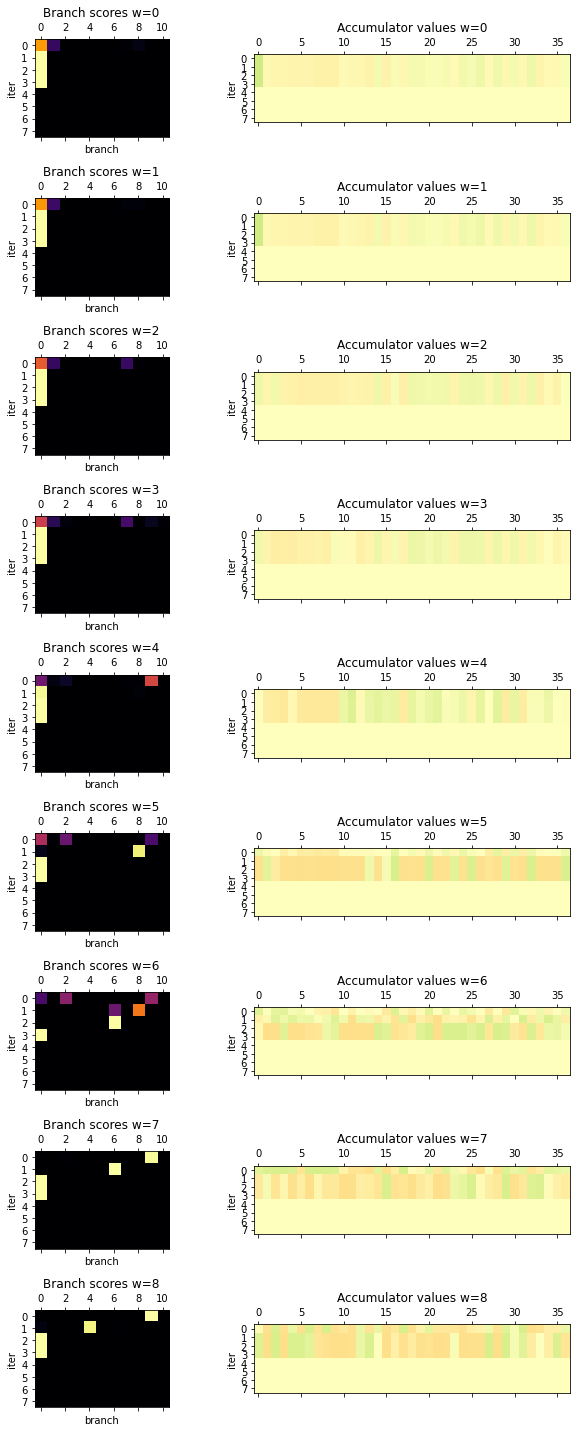

In [82]:
x, yh = num_to_vec(29, 66, 0, operation=11)
y = model.predict(x)
print(vec_to_num(y[0]))

plot_branch_trace(trace_model.predict(x))

In [ ]:
model.get_layer(index=2).weights